# ガウス過程

PHYSBOではガウス過程回帰を実行しながらベイズ最適化を行なっています。

そのため、学習データが与えられた際にガウス過程回帰を実行することもでき、学習済みモデルを利用したテストデータの予測も行うことができます。

ここでは、その手順について紹介します。


## 探索候補データの準備

本チュートリアルでは例として、Cuの安定した界面構造の探索問題を扱います。 目的関数の評価にあたる構造緩和計算には、実際には1回あたり数時間といったオーダーの時間を要しますが、本チュートリアルでは既に評価済みの値を使用します。問題設定については、以下の文献を参照してください。
S. Kiyohara, H. Oda, K. Tsuda and T. Mizoguchi, “Acceleration of stable interface structure searching using a kriging approach”, Jpn. J. Appl. Phys. 55, 045502 (2016).

データセットファイル [s5-210.csv](https://raw.githubusercontent.com/issp-center-dev/PHYSBO/master/examples/grain_bound/data/s5-210.csv) を保存し、次のように読み出します。

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import physbo


def load_data():
    A =  np.asarray(np.loadtxt('s5-210.csv',skiprows=1, delimiter=',') )
    X = A[:,0:3]
    t  = -A[:,3]
    return X, t

X, t = load_data()
X = physbo.misc.centering( X )


Cythonized version of physbo is used


## 学習データの定義

対象データのうち、ランダムに選んだ1割をトレーニングデータとして利用し、別のランダムに選んだ1割をテストデータとして利用します。

In [2]:
N = len(t)
Ntrain = int(N*0.1)
Ntest = min(int(N*0.1), N-Ntrain)

id_all   = np.random.choice(N, N, replace=False)
id_train  = id_all[0:Ntrain]
id_test = id_all[Ntrain:Ntrain+Ntest]

X_train = X[id_train]
X_test = X[id_test]

t_train = t[id_train]
t_test = t[id_test]

print("Ntrain =", Ntrain)
print("Ntest =", Ntest)

Ntrain = 1798
Ntest = 1798


## ガウス過程の学習と予測

以下のプロセスでガウス過程を学習し、テストデータの予測を行います。

1. ガウス過程のモデルを生成します。

2. X_train（学習データのパラメータ）, t_train（学習データの目的関数値）を用いてモデルを学習します。

3. 学習されたモデルを用いてテストデータ(X_test)に対する予測を実行します。

共分散の定義(ガウシアン)

In [3]:
cov = physbo.gp.cov.Gauss( X_train.shape[1],ard = False )

平均の定義

In [4]:
mean = physbo.gp.mean.Const()

尤度関数の定義(ガウシアン)

In [5]:
lik = physbo.gp.lik.Gauss()

ガウス過程モデルの生成

In [6]:
gp = physbo.gp.Model(lik=lik,mean=mean,cov=cov)
config = physbo.misc.set_config()

--------------------------------------------------------------------------------
         Use physbo.SetConfig instead.
--------------------------------------------------------------------------------


ガウス過程モデルを学習

In [7]:
gp.fit(X_train, t_train, config)

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 17286.344814363532
50 -th epoch marginal likelihood 3941.141158356132
100 -th epoch marginal likelihood 1224.4325203178405
150 -th epoch marginal likelihood 78.87839479900322
200 -th epoch marginal likelihood -701.4985461671986
250 -th epoch marginal likelihood -1344.3964878511624
300 -th epoch marginal likelihood -1676.1549909534815
350 -th epoch marginal likelihood -1815.6458851286318
400 -th epoch marginal likelihood -1917.6558525403716
450 -th epoch marginal likelihood -1968.1828578348936
500 -th epoch marginal likelihood -1998.5771581916174
Done



学習されたガウス過程におけるパラメタを出力

In [8]:
gp.print_params()



likelihood parameter =   [-2.76166841]
mean parameter in GP prior:  [-1.05925247]
covariance parameter in GP prior:  [-0.68395227 -2.67155333]




テストデータの平均値（予測値）および分散を計算

In [9]:
gp.prepare(X_train, t_train)
fmean = gp.get_post_fmean(X_train, X_test)
fcov = gp.get_post_fcov(X_train, X_test)

予測の結果

In [10]:
fmean

array([-1.04740175, -1.09605145, -1.0802498 , ..., -0.99629321,
       -1.16971609, -1.13126194])

分散の結果

In [11]:
fcov

array([0.00043518, 0.00045412, 0.00055981, ..., 0.0003406 , 0.00037195,
       0.00053075])

予測値の平均二乗誤差の出力

In [12]:
np.mean((fmean-t_test)**2)

0.011857078799698457

得られた回帰モデルについて、どの特徴量がどのくらい重要なのかを調べるための簡単な指標として permutation importance (PI)があります。
PHYSBOでは `get_permutation_importance` 関数で計算できます。

In [13]:
pi_mean, pi_std = gp.get_permutation_importance(X_train, t_train, n_perm=100)

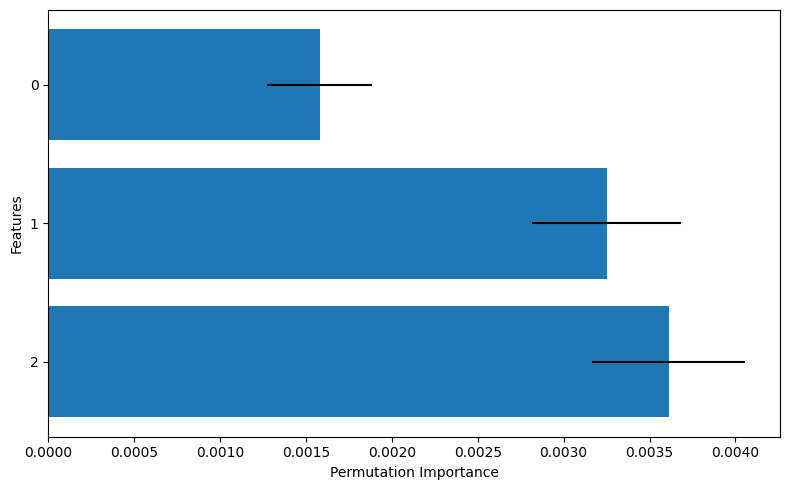

In [14]:
features = list(range(len(pi_mean)))

plt.figure(figsize=(8, 5))
plt.barh(
    features,
    pi_mean,
    xerr=pi_std,
)
plt.gca().invert_yaxis()
plt.yticks(features)
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.tight_layout()

このグラフにおいて、棒グラフはPIの平均値を、線分は標準偏差を示しており、0番の特徴量と比べて1,2番の特徴量のほうが重要そうだ、ということが読み取れます。

`gp.model` だけではなく, `policy` も `get_permutation_importance` 関数を持っています。
使い方は `policy.get_permutation_importance(n_perm)` です。
`policy` では保存してある学習済みデータに対してPIを計算するため、 `model` とは違い、改めて渡す必要はありません。

## 訓練済みモデルによる予測

学習済みモデルのパラメタをgp_paramsとして読み出し、これを用いた予測を行います。

gp_paramsおよび学習データ(X_train, t_train)を記憶しておくことで、訓練済みモデルによる予測が可能となります。

学習されたパラメタを準備(学習の直後に行う必要あり)

In [15]:
#学習したパラメタを１次元配列として準備
gp_params =  np.append(np.append(gp.lik.params, gp.prior.mean.params), gp.prior.cov.params)

gp_params

array([-2.76166841, -1.05925247, -0.68395227, -2.67155333])

学習に利用したモデルと同様のモデルをgpとして準備

In [16]:
#共分散の定義 (ガウシアン)
cov = physbo.gp.cov.Gauss( X_train.shape[1],ard = False )

#平均の定義
mean = physbo.gp.mean.Const()

#尤度関数の定義 (ガウシアン)
lik = physbo.gp.lik.Gauss()

#ガウス過程モデルの生成
gp = physbo.gp.Model(lik=lik,mean=mean,cov=cov)


学習済みのパラメタをモデルに入力し予測を実行

In [17]:
#学習済みのパラメタをガウス過程に入力
gp.set_params(gp_params)


#テストデータの平均値（予測値）および分散を計算
gp.prepare(X_train, t_train)
fmean = gp.get_post_fmean(X_train, X_test)
fcov = gp.get_post_fcov(X_train, X_test)

予測の結果

In [18]:
fmean

array([-1.04740175, -1.09605145, -1.0802498 , ..., -0.99629321,
       -1.16971609, -1.13126194])

分散の結果

In [19]:
fcov

array([0.00043518, 0.00045412, 0.00055981, ..., 0.0003406 , 0.00037195,
       0.00053075])

予測値の平均二乗誤差の出力

In [20]:
np.mean((fmean-t_test)**2)

0.011857078799698457

(注) 上の例では事前に登録されているXと同じものを利用して予測を行いました。
学習済みのモデルを利用してXに含まれていないパラメータ X_new に対して予測をしたい場合には、
学習モデルで使用したデータXの平均(X_{mean})と標準偏差(X_{std})を求めていただいたうえで、
X_{new} = (X_{new} - X_{mean}) / X_{std}
の変形を行うことで予測を行うことができます。
また、渡す際のデータ形式はndarray形式になっています。
そのため、X_{new}が一つのデータの場合には事前に変換する必要があります。
例えば、X_{new}が実数である場合には、
X_new = np.array(X_new).reshape(1)
などとして変換する必要があります。